## Introduction

https://www.youtube.com/watch?v=yZlLs5rb9II

Lesson Objectives
In the previous lesson, we built networking infrastructure with CloudFormation, including a VPC, subnets, Internet Gateway, NAT Gateways, and routing tables.

In the current lesson, we will create a new stack for our servers and associated resources in the previously created VPC. Yes, we will cross-reference the resources created in the previous stack in our new stack.

In particular, we will create the following resources using the CloudFormation template:

Security groups - Security group specify firewall rules. We will create two of them, one for a load-balancer and another for a web server.
Launch Template - A set of attributes used for configuring and launching EC2 instances with identical properties.
AutoScaling group - An autoscaling group ensures that a desired number of servers are always up and running, using Launch Templates to set the same configuration for all EC2 instances.
Load balancer - A load balancer distributes the incoming traffic uniformly across multiple servers (target group) within the same or different AZs. We will also create a listener and target group for the load balancer.
This is our goal infrastructure diagram for this lesson.

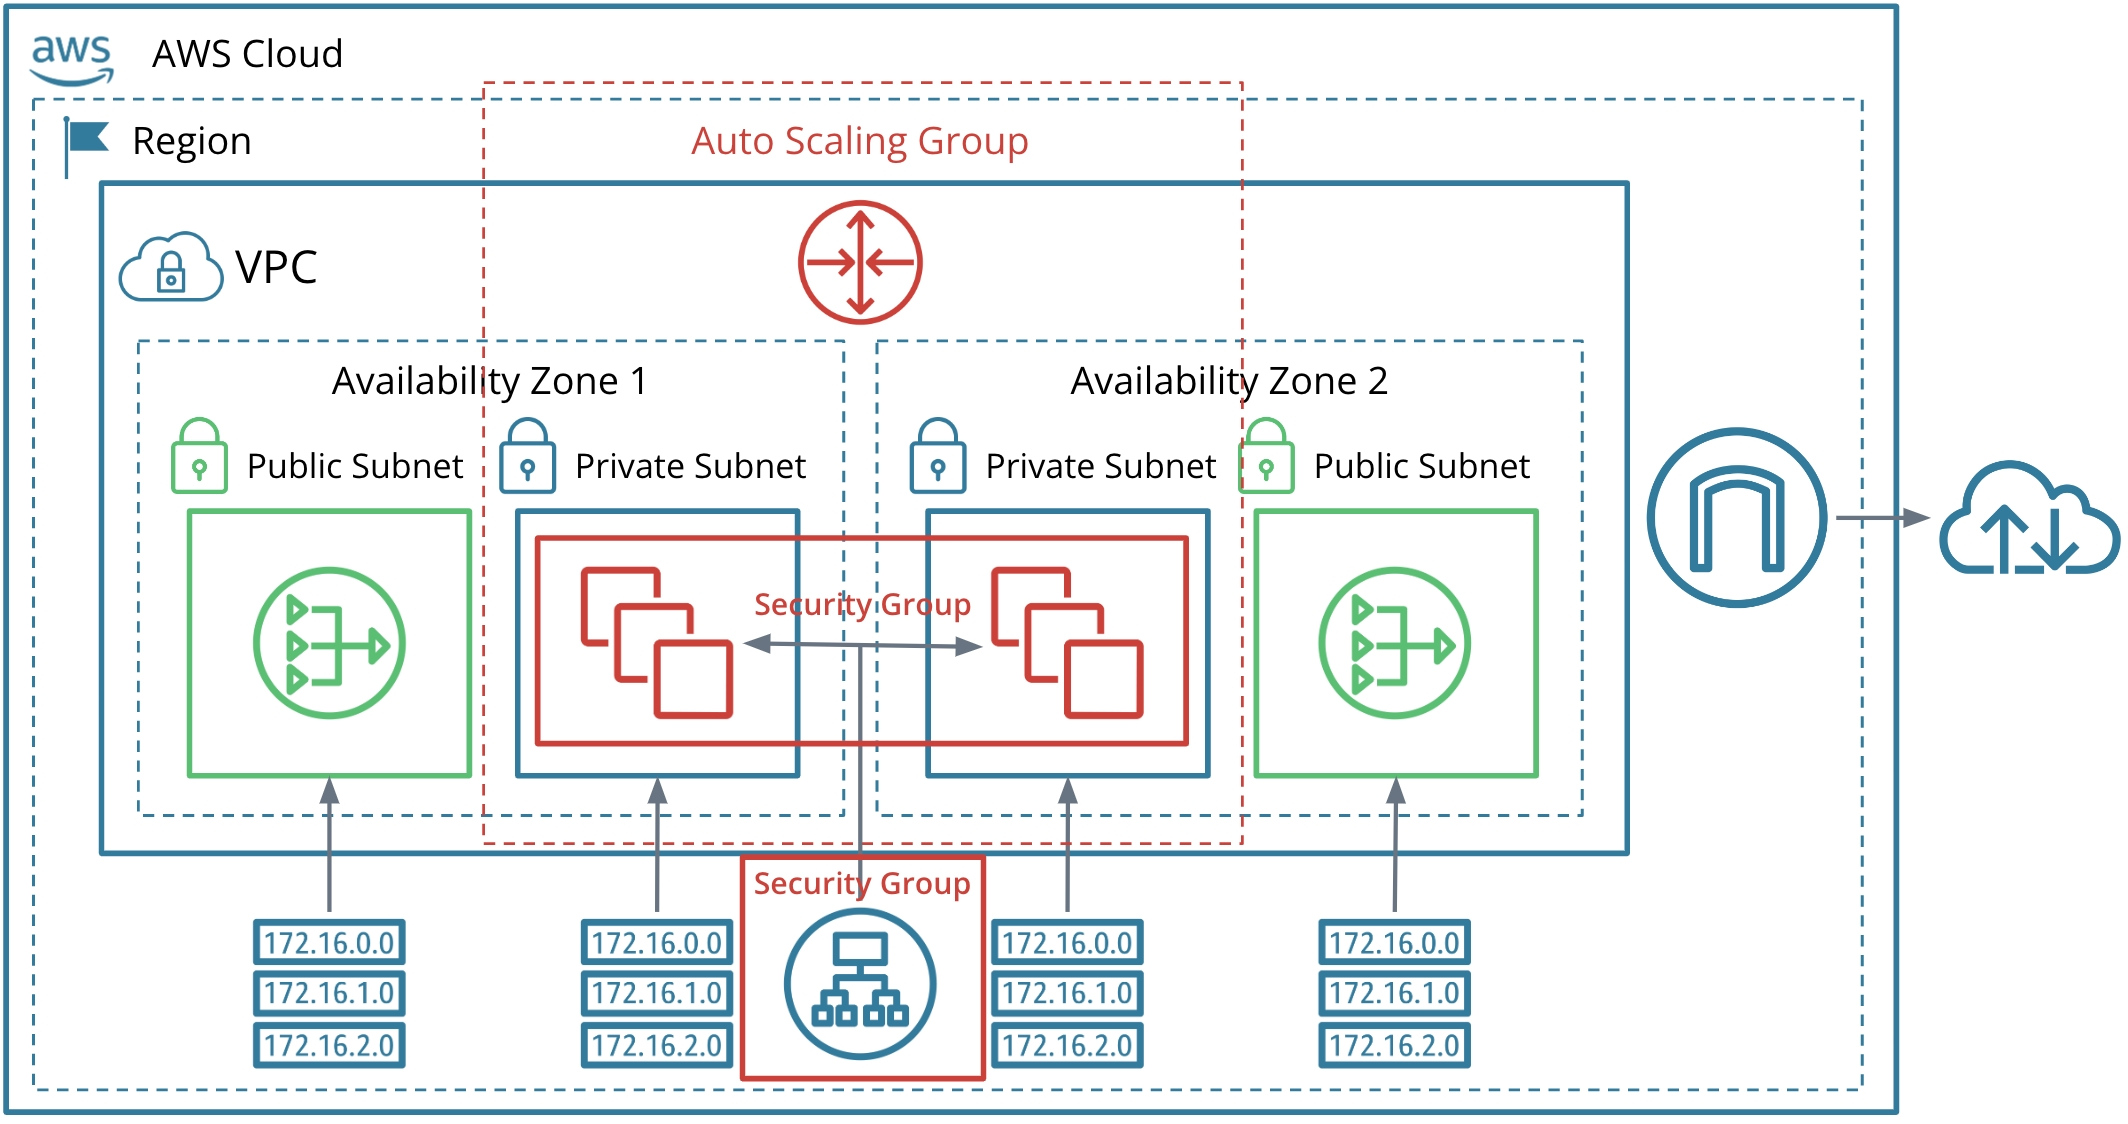

Lesson 4 Infrastructure Diagram

Upon completion of this lesson, you will be able to:

Create security groups with CloudFormation using the least privilege principle.
Centralize server configuration using Launch Templates in CloudFormation.
Deploy highly available servers with AutoScaling Groups in CloudFormation.
Apply load balancing principles to your servers using CloudFormation.

https://github.com/udacity/cd12352-Deploy-Infrastructure-as-Code/

## Setting Up Our Environment

The videos in this lesson will use the templates files servers.yml and server-parameters.json as a base to gradually build our own server template files: demoservers.yml and demoservers.json. The stack we create from this template will be built on top of our previously created network resources, so be sure to keep them running.

We strongly encourage you to follow the video demonstrations as well as use the available exercises to validate your knowledge.

The commands to run for creation and update of the demonstration stack are:

./create.sh demoserverstack demoservers.yml demoservers.json
./update.sh demoserverstack demoservers.yml demoservers.json

IMPORTANT
The network stack from the previous lesson includes NAT Gateways. They have an hourly charge associated. Remember to delete your stack after completion.

## Creating Our Template Files for Server Infrastructure

https://www.youtube.com/watch?v=74wtww7Sdwo 

We've examined the process of creating a new infrastructure for servers and software. This requires creating a new YAML file and parameter file. The goal is to reference the output values of a previous networking script by using the same EnvironmentName parameter as before.

## Understanding Security Groups

Security groups control network access to AWS resources by using ingress and egress rules.

Ingress Rules
A list of rules for inbound traffic. Any rule you add here is a port you are opening to a specific IP/CIDR block or source security group.

If you don't specify any security group rules here, all inbound access to your resources is blocked by default.
If you add one or more rules, only requests from those destinations and ports are allowed.
For ingress rules, we want to limit inbound traffic, for security, to a single port or just a handful of ports required by the application we are running. For example, if it’s a public web server, it will require port 80 open to the world ( World = 0.0.0.0/0 ). Should you need the SSH port open, restrict this port only to your specific IP address.

Egress Rules
A list of rules for outbound traffic. Any rule you add here is a port and destination IP you allow your security group resources to access.

If you don't specify any security group rules here, all outbound access from your resources is allowed by default.
If you add one or more rules, only requests to those destinations and ports are allowed.
For outbound traffic, is not unusual to give the resource full access to the internet, so we give egress access to all ports, from 0 all the way to 65535.

Web servers vs Load Balancer Security Groups
In this lesson, we will create two Security groups, and it's important to understand the difference between them:

Load Balancer Security Group
Applied to the Load Balancer resource. Since the Load Balancer will be the entry point to our resources from the outside world, this security group will have an inbound rule allowing access to port 80 (since we're using that port in our particular example).

Web Servers Security Group
Applied to the instances created by the AutoScaling group. These instances should only be accessible from the Load Balancer, and not from the outside world. Let's assume our web application runs on port 80. Therefore, this security group will have an inbound rule on port 80, allowing access from the load balancer security group only.

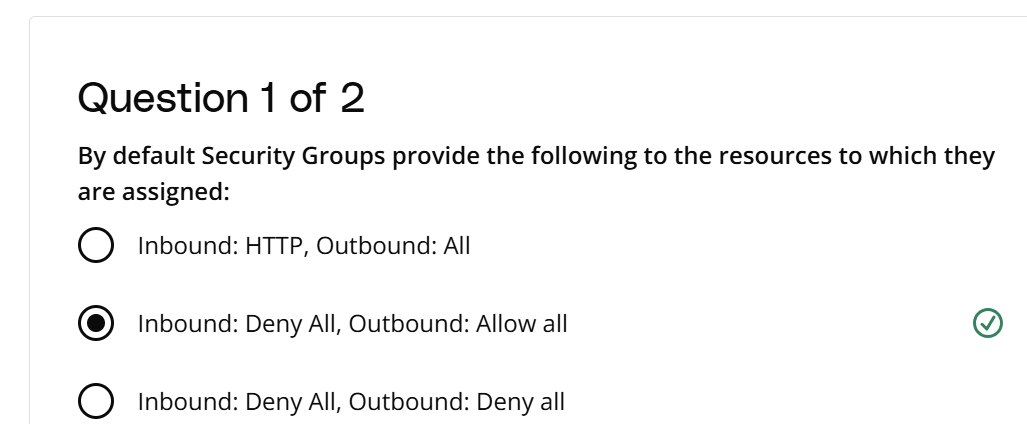

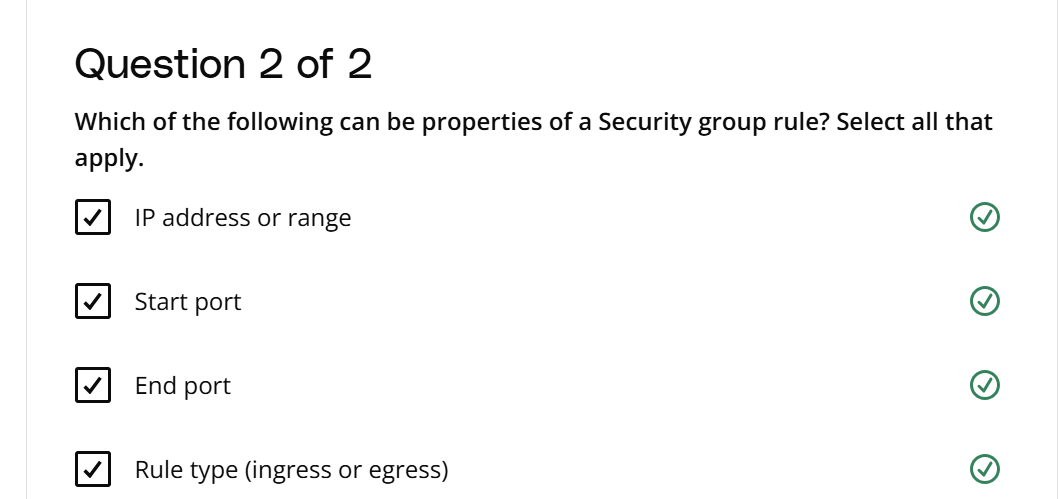

https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/security-group-rules-reference.html

## Security Groups

## Adding and Creating Security Groups
Let's go ahead and add the required security groups to our template.

https://www.youtube.com/watch?v=wOkYDzN4uN8

Security Group Syntax

The following is the syntax required to create a SecurityGroup:

Type: AWS::EC2::SecurityGroup
Properties: 
  GroupDescription: String
  GroupName: String
  SecurityGroupEgress: 
    - Egress
  SecurityGroupIngress: 
    - Ingress
  Tags: 
    - Tag
  VpcId: String

GroupDescription is a mandatory string value up to 255 characters without quotes. Use it to describe security group usage.
GroupName is similar to GroupDescription, but it's not a required property.
VpcId denotes the VPC ID in which you are creating the Security Group.
SecurityGroupIngress and SecurityGroupEgress are a list of rules meant to allow network traffic.

Intrinsic function: ImportValue
You probably noticed that we used a new intrinsic function for this resource. We briefly presented this function before, when studying outputs. As you have probably guessed, this is the way we can import output values from previous stacks into our current templates.

The parameter received by the function is that of the Export name, used in the source template Outputs definition.

VpcId:
  Fn::ImportValue:
    !Sub "${EnvironmentName}-vpc-id"

Quiz Question
Regarding this SecurityGroup definition:

Resources:
  QuizSecurityGroup:
    Type: AWS::EC2::SecurityGroup
    Properties:
      GroupDescription: Allow Internet access on port 22
      VpcId: !Ref MyVPC
      SecurityGroupIngress:
      - IpProtocol: tcp
        FromPort: 443
        ToPort: 443
        SourceSecurityGroupId: !Ref AnotherSecurityGroup
      SecurityGroupEgress:
      - IpProtocol: tcp
        FromPort: 0
        ToPort: 65535
        CidrIp: 0.0.0.0/0

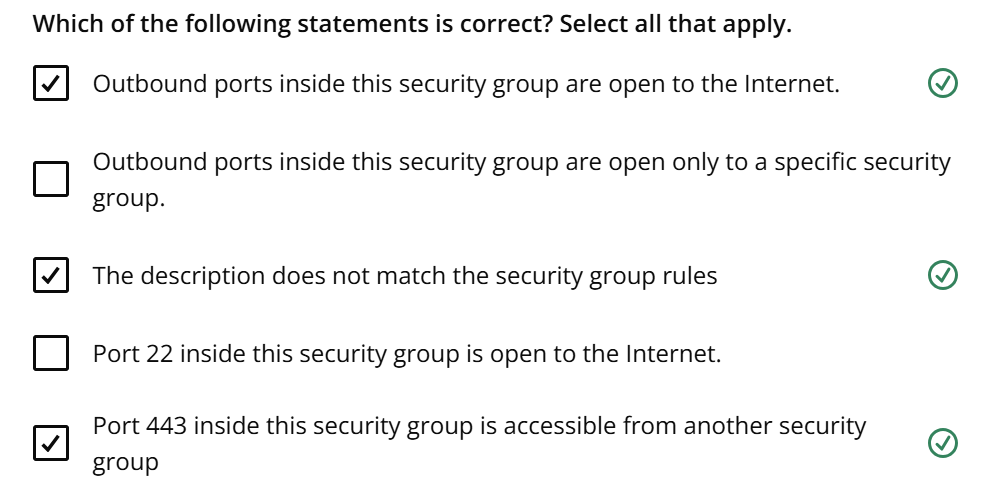

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-properties-ec2-security-group.html

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/intrinsic-function-reference-importvalue.html

## Exercise: Least Privilege Security Groups

A client of yours has asked you to review their security group configuration for one of their projects. He's concerned about the firewall rules not following best practices, in particular the least privilege principle. He has sent you this CloudFormation template snippet:

In [ ]:
Resources:
  VPC: 
    Type: AWS::EC2::VPC
    Properties:
      CidrBlock: 10.4.0.0/16
      EnableDnsHostnames: true
      Tags: 
      - Key: Name 
        Value: udacity-security-groups
  BastionsSecurityGroup:
    Type: AWS::EC2::SecurityGroup
    Properties:
      VpcId: !Ref VPC
      GroupDescription: Security group for Bastion servers
      SecurityGroupIngress:
      - IpProtocol: tcp
        FromPort: 22
        ToPort: 22
        CidrIp: 10.156.30.0/24
  ApplicationASecurityGroup:
    Type: AWS::EC2::SecurityGroup
    Properties:
      VpcId: !Ref VPC
      GroupDescription: Security group for Application A servers
      SecurityGroupIngress:
      - IpProtocol: tcp
        FromPort: 80
        ToPort: 80
        CidrIp: 0.0.0.0/0
      - IpProtocol: tcp
        FromPort: 22
        ToPort: 22
        SourceSecurityGroupId: !Ref BastionsSecurityGroup
  ApplicationBSecurityGroup:
    Type: AWS::EC2::SecurityGroup
    Properties:
      VpcId: !Ref VPC
      GroupDescription: Security group for Application B servers
      SecurityGroupIngress:
      - IpProtocol: tcp
        FromPort: 80
        ToPort: 80
        CidrIp: 10.156.36.0/24
      - IpProtocol: tcp
        FromPort: 22
        ToPort: 22
        SourceSecurityGroupId: !Ref BastionsSecurityGroup

There are three groups of servers: bastions or SSH jump boxes, servers hosting Application A, and servers hosting Application B. Each security group is attached to the servers based on its name.

Can you help him adjust his design so it follows security best practices?

Exercise Prompt
Adjust the provided CloudFormation template so its security groups provide only the following network permissions:

The operations team must be able to access the bastion servers using SSH (port 22) from their internal servers only. Their IP range is 10.156.30.0/24.
The operations team must be able access ApplicationA and ApplicationB servers using an SSH tunnel through the bastion server (port 22).
ApplicationA must be open to the Internet on port 80.
ApplicationB must only be open to the developers team, working from inside the IT office. The office IP range is 10.156.36.0/24.

## Solution: Least Privilege Security Groups

https://www.youtube.com/watch?v=2CzORJrAXoc

## Launch Templates

Having our security groups in place, we can now add our server resources. Since we want to create many identical servers managed by an AutoScaling Group, we must begin by defining the server attributes. This is achieved with a Launch Template resource.

Adding and Creating Launch Templates

https://www.youtube.com/watch?v=-voPojPxV-A

AWS::EC2::LaunchTemplate syntax
This is the syntax for an AWS::EC2::LaunchTemplate:


Type: AWS::EC2::LaunchTemplate
Properties: 
  LaunchTemplateData: 
    LaunchTemplateData
  LaunchTemplateName: String

In other words, a launch template comprises two main components: LaunchTemplateName and LaunchTemplateData. The LaunchTemplateName is optional, and LaunchTemplateData will have the detailed configuration for the instances we want.

Adding a Launch Template
Let's imagine we want to define a launch template for a collection of EC2 instances with the following attributes:

Use the t2.micro instance type, since that's included in the Free Tier plan(opens in a new tab) from AWS.
Use a security group called WebServerSecGroup.
Use an Ubuntu 22.04 machine image. For this, you must reference the AMI id. If you don't know the id you need, you can always visit the Ubuntu Cloud Image Finder(opens in a new tab) and filter there. In our case, we will use the ami-0557a15b87f6559cf id.
A 50 GiB EBS volume size.
A bash init script printing a hello message.
This is how we add it to our template:

Resources:
  WebAppLaunchTemplate:
    Type: AWS::EC2::LaunchTemplate
    Properties:
      LaunchTemplateName: !Sub "web-servers-template"
      LaunchTemplateData:
        UserData:
          echo "Hello, I'm a server ready to work!"
        ImageId: ami-0557a15b87f6559cf
        SecurityGroupIds:
          - !Ref WebServerSecGroup
        InstanceType: t2.micro
        IamInstanceProfile:
          Name: !Ref WebServerInstanceProfile
        BlockDeviceMappings:
        - DeviceName: "/dev/sdk"
          Ebs:
            VolumeSize: '50'

Let's review the LaunchTemplateData components:

UserData: in here you add all the init scripts for your instances. Consider that whatever commands you include here, will be executed for each and every instance created by the AutoScaling group.
ImageId: the internal AWS id for the machine image (AMI) we're using.
SecurityGroupIds: a list of Security Group ids. Include any security groups you want to attach to this collection of instances.
InstanceType: the type of instance we want our servers to be.
BlockDeviceMappings: storage configuration for our instances, declaring a 50 GiB EBS disk in our scenario.
There are several other attributes you can define in your Launch Templates. Feel free to inspect the AWS::EC2::LaunchTemplate resource reference to discover more.

One of these attributes, the IamInstanceProfile, is a reference to an IAM Instance Profile resource. This resource encapsulates an IAM role, and allows our servers to assume an IAM role so it can access other AWS resources.

Assuming IAM roles from Launch Template instances
The following snippet creates an IAM instance profile with an IAM role granting access to an S3 bucket. Notice that the IAM role has an AssumeRolePolicyDocument property, which declares that EC2 can assume the role and use it. This allows our EC2 instances to assume the role and access the required S3 bucket.

Resources:
  WebServerInstanceRole:
    Type: AWS::IAM::Role
    Properties:
      RoleName: "web-servers-instance-role"
      AssumeRolePolicyDocument:
        Version: '2012-10-17'
        Statement:
        - Effect: 'Allow'
          Principal:
            Service:
            - 'ec2.amazonaws.com'
          Action:
          - 'sts:AssumeRole'
      Policies:
        - PolicyName: s3
          PolicyDocument:
            Version: '2012-10-17'
            Statement:
            - Effect: Allow
              Action:
              - 's3:PutObject*'
              - 's3:GetObject*'
              - 's3:DeleteObject*'
              Resource:
                - !Ref SomeBucketArn
  WebServerInstanceProfile:
    Type: AWS::IAM::InstanceProfile
    Properties:
      Path: '/'
      Roles:
      - !Ref WebServerInstanceRole

## CloudFormation Capabilities Note
Remember though, that to create these IAM resources, you need to add the --capabilities flag to the CloudFormation CLI command, using either theCAPABILITY_NAMED_IAM or CAPABILITY_IAM values.

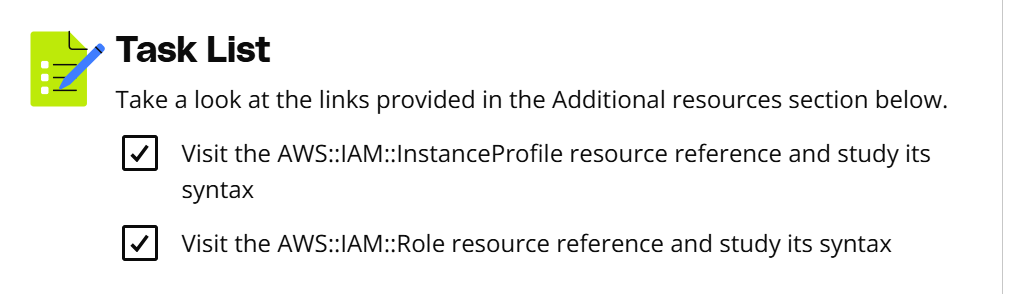

Launch Template versions
Each time you update a launch template, a new version of the same resource is created. In real world scenarios, you will usually want to use the newest version of your launch template. This attribute of the AWS::EC2::LaunchTemplate resource is called LatestVersionNumber, and can be accessed like this (using the WebAppLaunchTemplate logical ID from before):

!GetAtt WebAppLaunchTemplate.LatestVersionNumber

Quiz Question
Visit the AWS::EC2::LaunchTemplate resource reference page and take a look at its properties. Match the following LaunchTemplateData properties with their use cases.

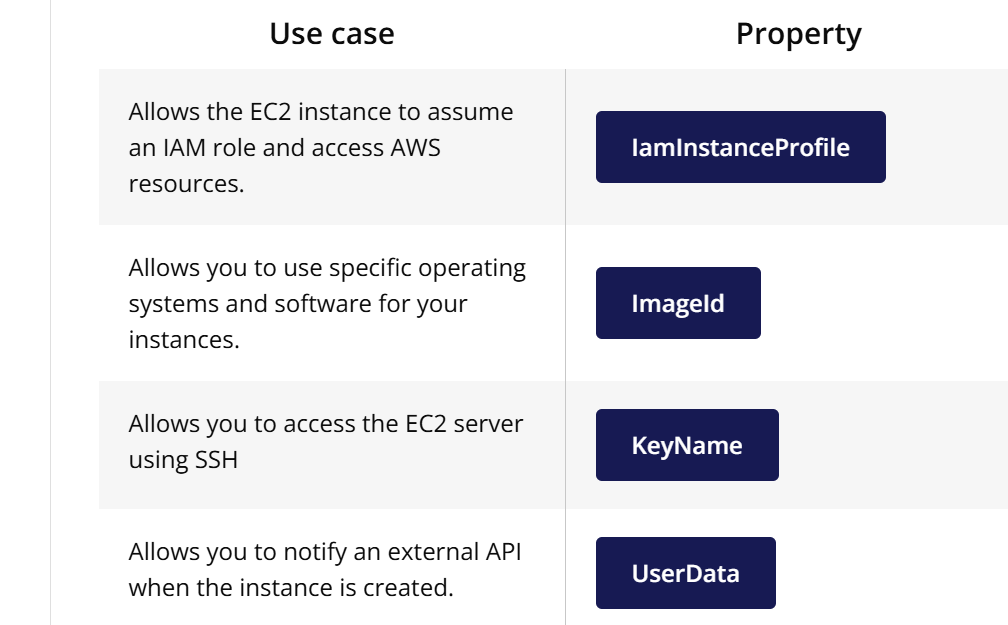

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-resource-ec2-launchtemplate.html

https://cloud-images.ubuntu.com/locator/

## AutoScaling Groups

Now that we have the properties for our EC2 instances well defined in a launch template, we can create an AutoScaling group to manage a required number of healthy servers.

## Adding and Creating AutoScaling Groups

https://www.youtube.com/watch?v=tcOE_p_Sb90

AutoScaling groups: Things to remember

An Autoscaling group is a logical group of EC2 instances that share a similar configuration. This AWS service monitors the EC2 instances and automatically adjusts the running count by adding/removing EC2 instances, ensuring that a desired number of servers (EC2 instances) are always up and running.

Two important concepts to remember.

Scaling policy: defines the criteria/conditions used to decide when to Add or Remove Servers from your Auto Scaling Group. For example, you could create a CloudWatch Alarm with a custom metric that counts the number of web visitors in the last 2 hours; if the number is less than 100, perhaps a single server is enough. This will be a trigger to scale down if there is more than one server running at the time. Other potential metrics are CPU utilization, network traffic, and so forth.
Launch Templates: defines the common configuration, such as AMI, instance-type, security-group, key pair, etc, for the instances in the AutoScaling group. For example: an application requires 2GB RAM , 4 vCPUs, 10GB of Disk Space, Java runtime version 8 or NodeJS 10.0. All this on top of a standard distribution of Linux or Windows.
AWS::AutoScaling::AutoScalingGroup syntax
This is how we would add an AutoScaling group to our template:

AWS::AutoScaling::AutoScalingGroup syntax
This is how we would add an AutoScaling group to our template:

Resources:
  WebAppGroup:
    Type: AWS::AutoScaling::AutoScalingGroup
    Properties:
      VPCZoneIdentifier:
      - Fn::ImportValue: 
          !Sub "${EnvironmentName}-private-subnets"
      LaunchTemplate:
        LaunchTemplateId: !Ref WebAppLaunchTemplate
        Version: !GetAtt WebAppLaunchTemplate.LatestVersionNumber
      MinSize: '2'
      DesiredCapacity: '2'
      MaxSize: '3'
      TargetGroupARNs:
      - Ref: WebAppTargetGroup

In the code above:

The VPCZoneIdentifier property is a list of subnet IDs for a virtual private cloud (VPC) where instances in the Auto Scaling group can be created. In this example, we are using the private subnets from our network stack.
The LaunchTemplate property contains the id and the latest version of our LaunchTemplate AWS resource, as created in the previous lesson.
The MinSize & MaxSize properties let us know the range of machines we will be running, which also alerts us to the min/max costs we can be expecting from these machines.
The DesiredCapacity attribute tells the AutoScaling service what's the target size for our group.
The TargetGroupARNs property is a list of Target Groups to be registered with an Elastic Load Balancer. We will create and explain this resource in the following sections.

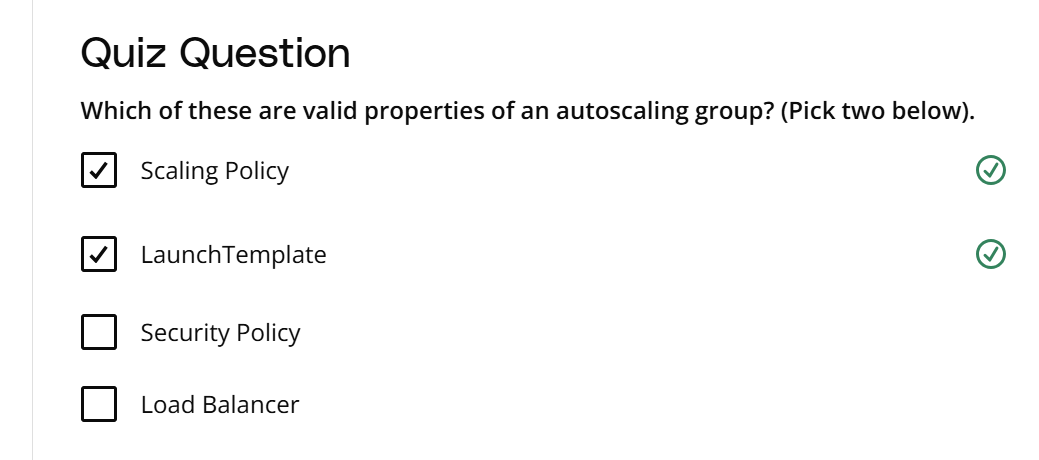

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-properties-as-group.html

## Exercise: Autoscaling WebApp Servers

The development team in your organization has asked you to deploy a new collection of EC2 instances for a web application they're working on. You will need to create this resource in the development account, although they intend to use your CloudFormation template in several environments, with different group sizes for each one. You decide to use a Launch Template for your server parameters, as well as an AutoScaling group to keep the appropriate number of servers alive at all times.

The EC2 instances will be placed in an already existing VPC network, managed by a separate CloudFormation stack. This network template is available in the starter folder for this exercise, in the GitHub repository solutions folder.

Exercise Prompt
Create a new stack for your web application resources with the following considerations:

Create first the network stack using the template available in the starter folder for this exercise.
Import the required networking values from the network stack using!ImportValue.
The application will be running on port 3000. The EC2 instances must have their own security group attached, allowing access to port 3000 from 10.11.0.0/16.
The EC2 instances must use the t2.micro instance type, a 10 GiB EBS disk, and any available Ubuntu AMI.
The AutoScaling group should deploy the instances in the private subnets of the existing VPC.
The AutoScaling group size goes between 1 and 6 instances depending on the environment.
The desired capacity must be passed as a parameter. Make it default to 1.
IMPORTANT

This exercise solution includes EC2 instances. Although t2.micro is included in the free tier plan, you might have associated hourly charges if you no longer have that plan available or keep EC2 instances running for a long time. Remember to delete your stack after completion.

## Solution: Autoscaling WebApp Servers

https://www.youtube.com/watch?v=1z7wp6XRebQ

## Load Balancer resources

Now that we have our AutoScaling group ready, we can proceed to create our Load Balancer. However, there are several related resources we need to understand before. We will review them in this section. These are:

The Load Balancer itself
Target groups, for grouping EC2 instances and triggering health checks.
Listeners, for receiving load balancer connections on specific ports.
Listener rules, for declaring specific behaviors in each listener, like forwarding to our AutoScaling group.

## Load Balancer: Things to remember
We learned earlier that a load-balancer(opens in a new tab) automatically distributes incoming application traffic across multiple servers (EC2 instances). These servers need not essentially be present in a single subnet. They (servers) can span across numerous subnets in a given VPC. In our example, these servers are residing in the private subnets.

A load balancer is not exactly a part of Auto Scaling. Still, it helps answer the question: "If I am running a web application in 20 different servers, how do I set up a single point of entry that guarantees an even workload distribution across all 20 servers?" The answer is a load balancer.

A load balancer allows you to reduce your Autoscaling down to 1 server at night when very few people are using your web application, and then Scale up to 10 or more servers during the day, when hundreds or thousands may be using it. The user doesn't experience any difference in availing of the services due to auto-scaling.

https://docs.aws.amazon.com/elasticloadbalancing/latest/application/introduction.html

## What is a Listener and Listener Rule?
A load balancer requires a listener. A listener(opens in a new tab) is a process that checks for connection requests using the protocol and port that you specify in your code. In comparison, a listener rule determines how the load balancer routes request to the registered targets. For example, a listener for an application load balancer will route the particular request to a specific target group based on some conditions we specify, such as URL path.

## What is a Target Group?
A target group(opens in a new tab) is a logical group of EC2 instances spanning across numerous subnets in a given VPC. You must explicitly register an EC2 instance with a target group, after which it will be called a target. In our example, the autoscaling group manages all EC2 instances in the target group, meaning it will automatically add/remove the instances to/from the target group.

https://docs.aws.amazon.com/elasticloadbalancing/latest/application/load-balancer-listeners.html

https://docs.aws.amazon.com/elasticloadbalancing/latest/application/load-balancer-target-groups.html

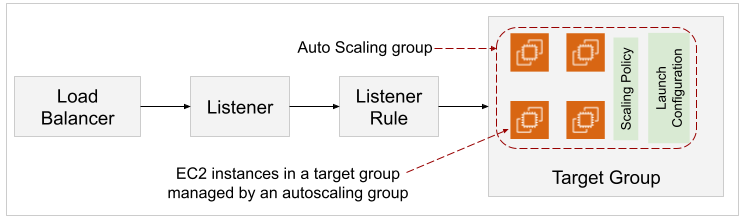

Relationship between a Load balancer, Listener, Listener Rule, Target group, and an Autoscaling group. We will code them all.

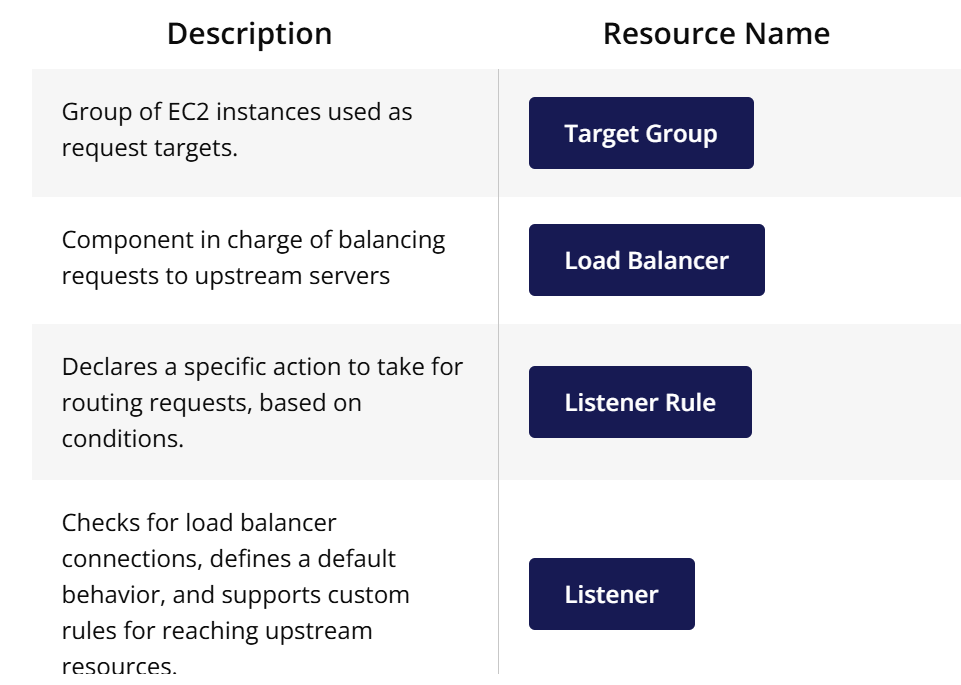

## Adding Load Balancer Resources

https://www.youtube.com/watch?v=09GYWhR_UjQ

Relationship between Target Groups and Auto Scaling groups.
A load balancer is a device that simply forwards traffic, evenly across a group of servers, known as a Target Group.
The problem is, we can’t specifically name those servers, because if they are part of an Auto Scaling group, this means that they can come and go as demand for your application increases or decreases.
We need to associate the previously created AutoScaling group with the load balancing service, specifically with the target groups. This is achieved by adding a new property to the AWS::AutoScaling::AutoScalingGroup.

The property is called TargetGroupARNs, and it requires a reference to the AWS::ElasticLoadBalancingV2::TargetGroup resource in your template.

Resources:
  SomeAutoscalingGroup:
    Type: AWS::AutoScaling::AutoScalingGroup
    Properties:
      VPCZoneIdentifier: !Ref SomePrivateSubnetLists
      LaunchTemplate:
        LaunchTemplateId: !Ref SomeLaunchTemplate
        Version: !GetAtt SomeLaunchTemplate.LatestVersionNumber
      MinSize: '0'
      DesiredCapacity: '2'
      MaxSize: '4'
      TargetGroupARNs:
      - Ref: SomeTargetGroup

AWS::ElasticLoadBalancingV2::TargetGroup
Health Checks are the requests your Application Load Balancer sends to its registered targets. These periodic requests test the status of these targets. You can see us defining our Health Check properties in the code below:

Resources:
  WebAppTargetGroup:
    Type: AWS::ElasticLoadBalancingV2::TargetGroup
    Properties:
      HealthCheckIntervalSeconds: 10
      HealthCheckPath: /
      HealthCheckProtocol: HTTP
      HealthCheckTimeoutSeconds: 8
      HealthyThresholdCount: 2
      Port: 80
      Protocol: HTTP
      UnhealthyThresholdCount: 5
      VpcId: 
        Fn::ImportValue:
          Fn::Sub: "${EnvironmentName}-VPCID"

In the above example we specify the following:

The port where our targets receive traffic - Port: 80
The protocol the load balancer uses when performing health checks on targets - HealthCheckProtocol: HTTP
The time it takes to determine a non-responsive target is unhealthy - HealthCheckIntervalSeconds: 10
The number of healthy/unhealthy checks required to change the health status - HealthyThresholdCount: 2 UnhealthyThresholdCount: 5
The healthy threshold represents the number of consecutive health check successes required before considering an unhealthy target healthy. An unhealthy threshold shows the number of consecutive health check failures required before considering a target unhealthy.

AWS::ElasticLoadBalancingV2::LoadBalancer
Our load balancer will be present in the public subnet, and use the dedicated security group we created earlier. The code will look like:

Resources:
  WebAppLB:
    Type: AWS::ElasticLoadBalancingV2::LoadBalancer
    Properties:
      Subnets:
      - Fn::ImportValue: !Sub "${EnvironmentName}-PUB1-SN"
      - Fn::ImportValue: !Sub "${EnvironmentName}-PUB2-SN"
      SecurityGroups:
      - Ref: LBSecGroup

AWS::ElasticLoadBalancingV2::Listener
The listener to attach to our load balancer will be:

Resources:
  Listener:
    Type: AWS::ElasticLoadBalancingV2::Listener
    Properties:
      DefaultActions:
      - Type: forward
        TargetGroupArn:
          Ref: WebAppTargetGroup
      LoadBalancerArn:
        Ref: WebAppLB
      Port: '80'
      Protocol: HTTP

It will listen to load balancer connections on port 80, and forward them to the target group. Notice it also has a default action. Should no listener rules be created or matched, the default action will be triggered.

## AWS::ElasticLoadBalancingV2::ListenerRule
A Listener requires a Listener Rule. The Listener Rule below will determine how (condition) the load balancer's connection requests are routed to the registered targets.

Resources:
  ALBListenerRule:
      Type: AWS::ElasticLoadBalancingV2::ListenerRule
      Properties:
        Actions:
        - Type: forward
          TargetGroupArn: !Ref 'WebAppTargetGroup'
        Conditions:
        - Field: path-pattern
          Values: [/]
        ListenerArn: !Ref 'Listener'
        Priority: 1

The above listener rule will route all connection requests with the default root (/) endpoint to the specified target group.

Had our application served two different API endpoints, we could have created a dedicated target group for each API endpoint. The listener rule will correspondingly route the first endpoint's connection requests to one target group and the requests for other endpoints to the second target group.

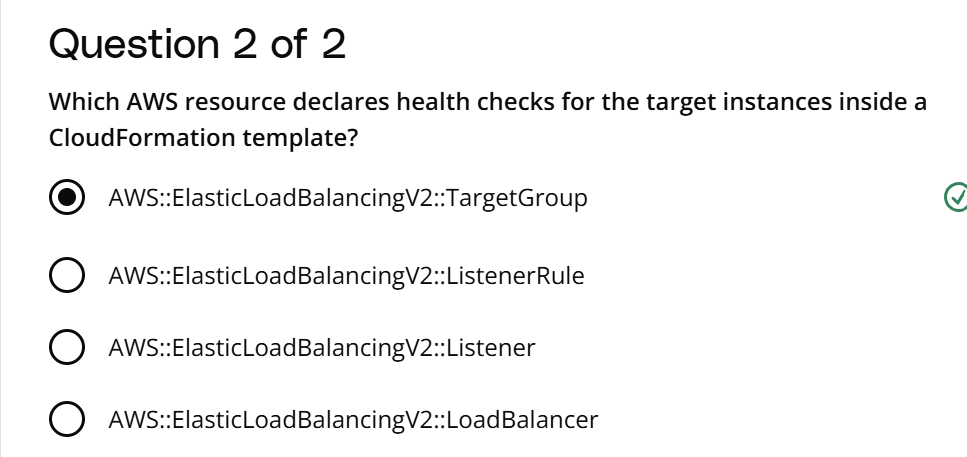

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-resource-elasticloadbalancingv2-loadbalancer.html


https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-resource-elasticloadbalancingv2-targetgroup.html

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-resource-elasticloadbalancingv2-listener.html

https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/aws-resource-elasticloadbalancingv2-listenerrule.html

https://docs.aws.amazon.com/elasticloadbalancing/latest/application/target-group-health-checks.html

## Application Load Balancer

Reviewing Load Balancer Creation

https://www.youtube.com/watch?v=srybWC8LovI

Our Application 

And now you've made it. Let's review again the infrastructure diagram showing all resources created so far.

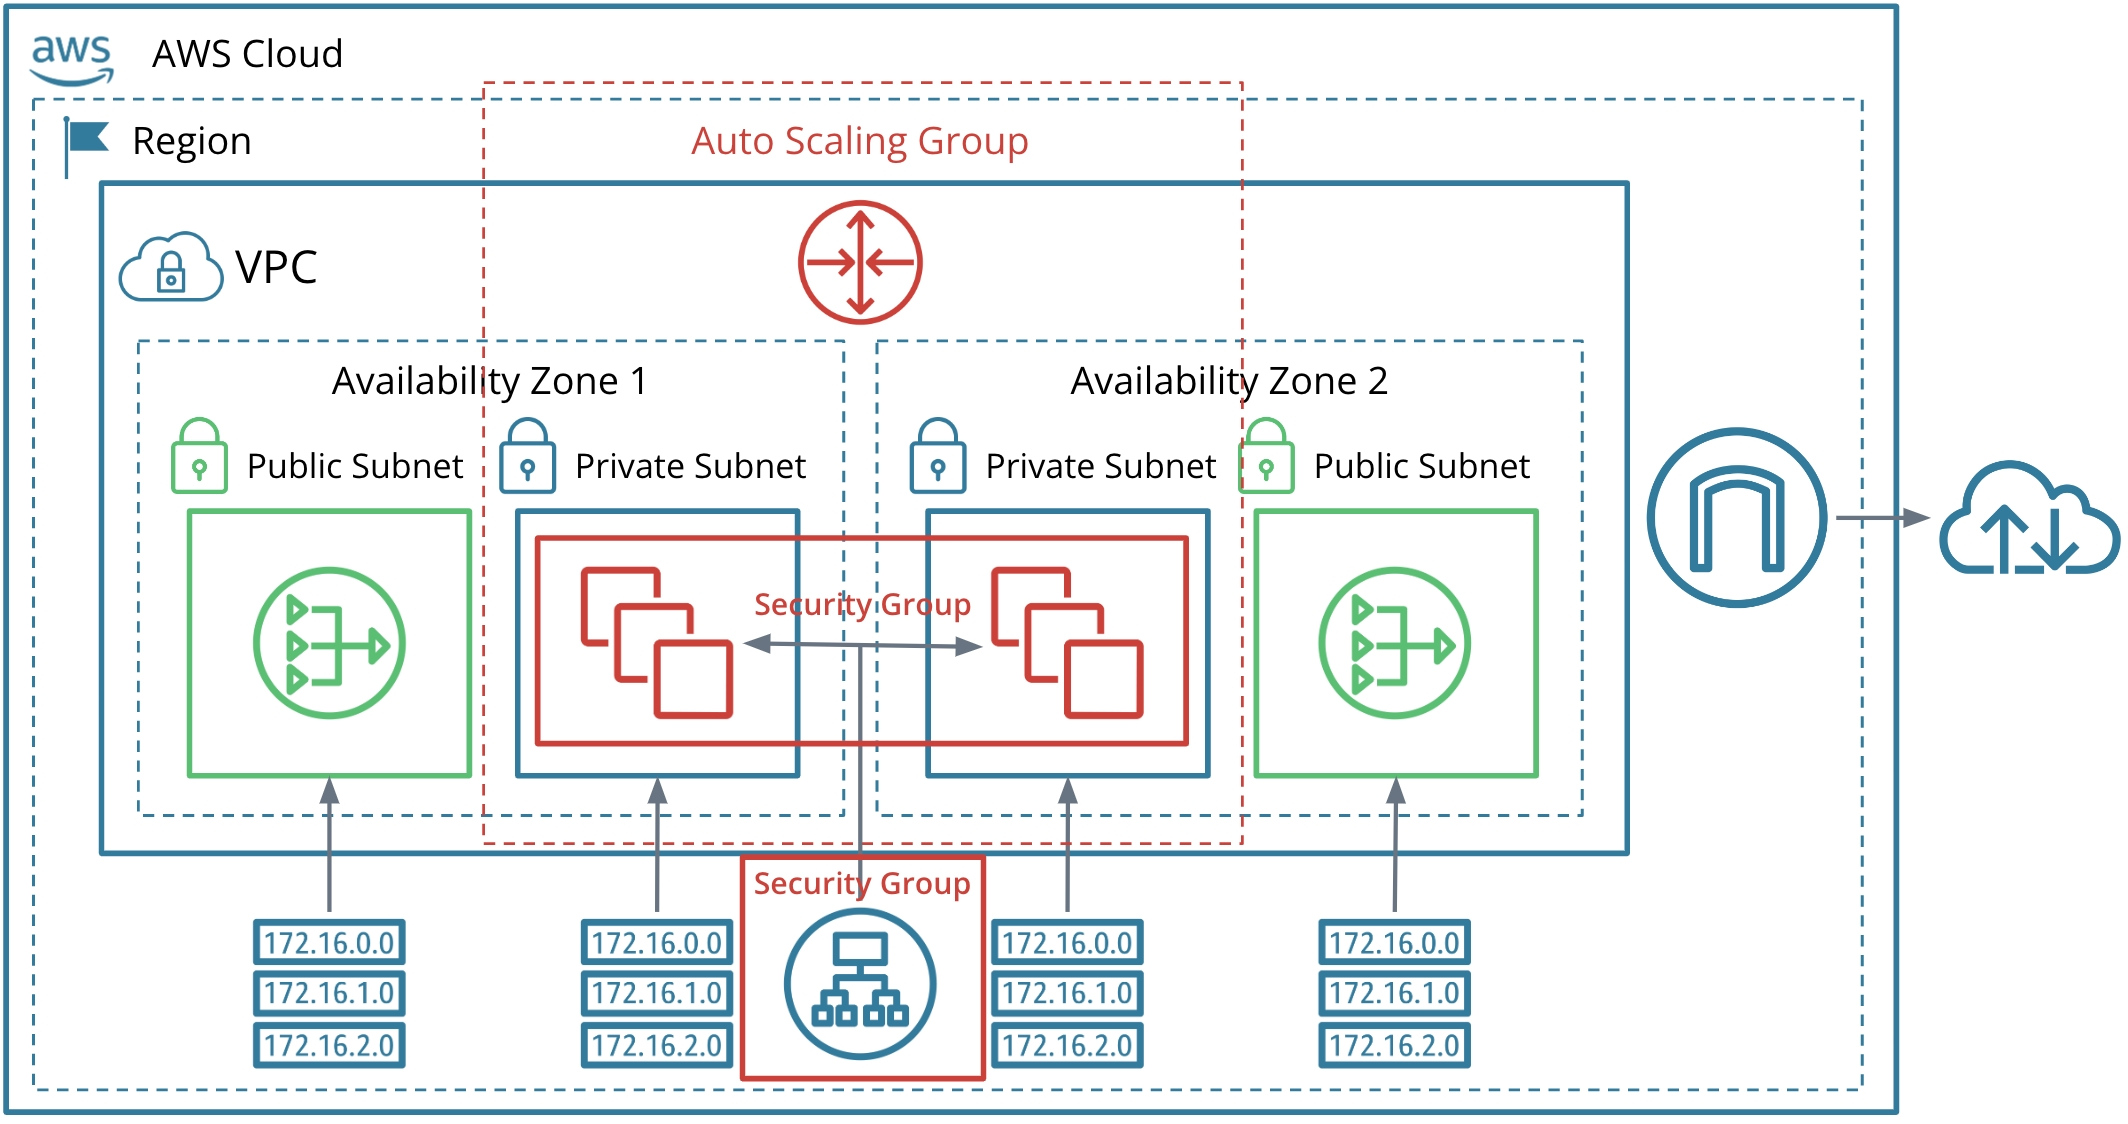

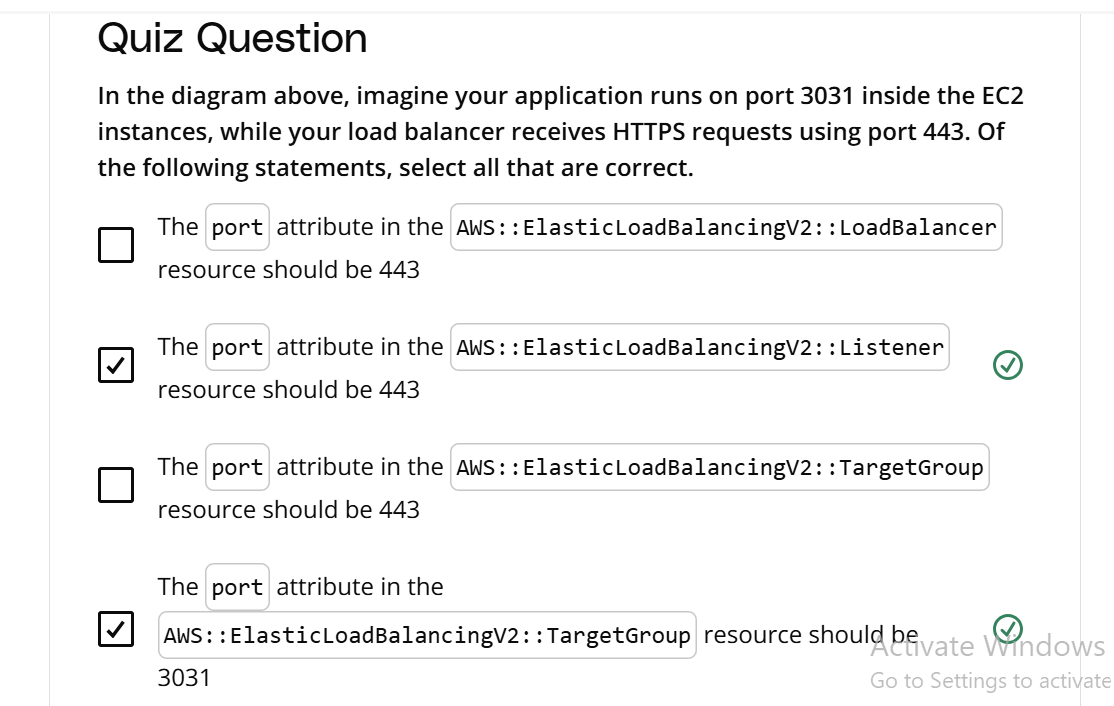

## Exercise: Load Balancing WebApp Servers

In the previous exercise, you've already created the launch template for your development team request. However, you know that for the staging and production environments, you will need up to 6 instances running at the same time. It's time to add a Load Balancer in front of your servers, to properly distribute traffic across them.

Exercise Prompt
Using the same stack from the previous exercise, add all the required resources to load balance the website requests. Remember to deploy the starter network stack also, for network imports.

Your requirements are:

You must use an Application Load Balancer, deployed to the VPC public subnets.
This ALB must have its own security group created and attached, allowing access to port 80 from 0.0.0.0/0.
Instances should only allow access on port 3000 from the load balancer's security group.
The ALB listener must use port 80, as this will be the port used to access the load balancer.
A single ALB listener rule should forward traffic to the instances target group, for any path.
The target group must include a health check on port 3000. Choose the parameters you find suitable.
IMPORTANT

This exercise solution includes EC2 instances. Although t2.micro instances are included in the free tier plan, you might have associated hourly charges if you no longer have that plan available or kept EC2 instances running for a long time. Remember to delete your stack after completion.

## Solution: Load Balancing WebApp Servers

https://www.youtube.com/watch?v=Ibiu6RUhsDs

## Conclusion

https://www.youtube.com/watch?v=-tY6lyLsmfE

Summary
As this lesson comes to an end, you should now be able to:

Create security groups with CloudFormation using the least privilege principle.
Centralize server configuration using Launch Templates in CloudFormation.
Deploy highly available servers with AutoScaling Groups in CloudFormation.
Apply load balancing principles to your servers using CloudFormation.